In [33]:
import gc
import timm
import copy
import random as rd 
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import Subset
from torch.optim import Adam, SGD 
from torch.utils.data import Subset, Dataset, DataLoader, ConcatDataset

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score 
from sklearn.model_selection import train_test_split
from collections import defaultdict, Counter

In [34]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device: ", device)

Using device:  mps


In [35]:
transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize((224, 224)), 
    torchvision.transforms.ToTensor()
])

In [36]:
dataset = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=transform)

In [37]:
subset_size = int(0.2 * len(dataset))  # Use 20% of the dataset

# Randomly select a subset of the dataset
subset_indices = torch.randperm(len(dataset))[:subset_size]
subset = Subset(dataset, subset_indices)

# Now split the subset into training, validation, and test sets
total_size = len(subset)
train_data, val_data, test_data = torch.utils.data.random_split(subset, [int(total_size * 0.8), int(total_size * 0.1), int(total_size * 0.1)])

# Print sizes
print("Subset size: ", subset_size)
print("Train size: ", len(train_data))
print("Val size: ", len(val_data))
print("Test size: ", len(test_data))

# Define DataLoader for each set
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)


Subset size:  20000
Train size:  16000
Val size:  2000
Test size:  2000


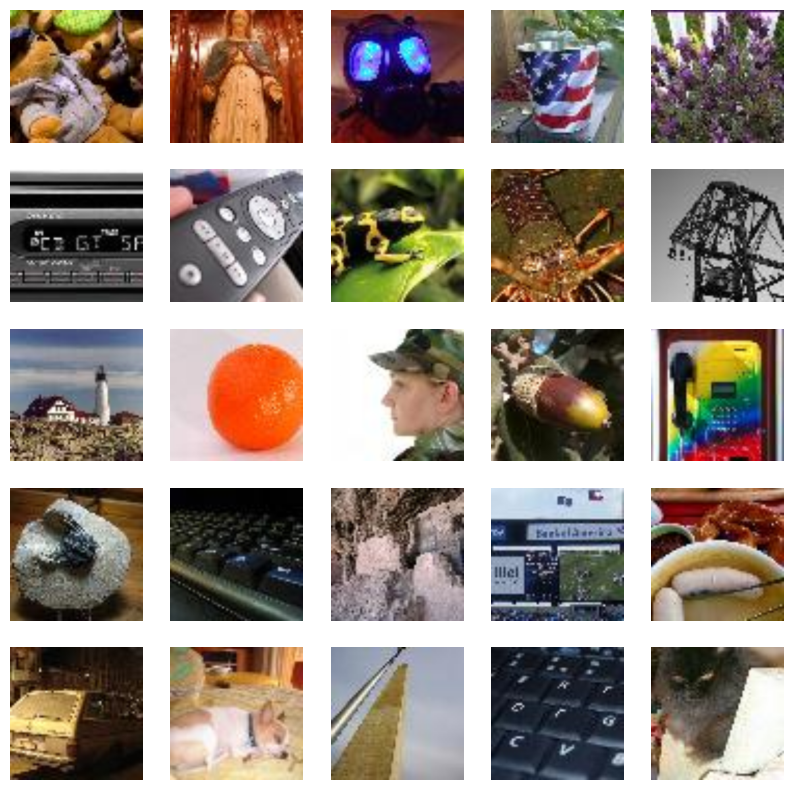

In [38]:
plt.figure(figsize=(10, 10))
for i in range(25):# Displaying the first 25 images as an example
    index = rd.randint(0, len(dataset)-1)
    plt.subplot(5, 5, i + 1)
    image = dataset[index][0].permute(1,2,0).numpy()
    plt.imshow(image)
    plt.axis('off')

plt.show()

In [39]:
def criterion(outputs, targets):
    loss = nn.MSELoss()(outputs, targets)
    return loss

In [40]:
class EncoderModel(nn.Module):
    def __init__(self, model_name, num_classes=200):
        super(EncoderModel, self).__init__()
        self.model = timm.create_model(model_name, pretrained=True)
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Replace classifier with identity to get features from penultimate layer
        self.final_linear = nn.Linear(self.model.get_classifier().in_features, num_classes)
        self.model.classifier = nn.Identity()

        # Dictionary to store the output of intermediate layers
        self.feature_maps = {}

    def _hook_fn(self, module, input, output):
        """Store the output of the layer in the feature_maps dict"""
        self.feature_maps[module] = output

    def register_hooks(self):
        """Registers a forward hook on layers you want to capture features from."""
        # Example: You can register hooks on specific layers
        for name, layer in self.model.named_modules():
            if isinstance(layer, nn.Conv2d):  # Example: Register hooks for Conv2D layers
                layer.register_forward_hook(self._hook_fn)

    def forward(self, images):
        self.feature_maps.clear()
        features = self.model(images)
        output = self.final_linear(features)
        return output  # Return raw logits

In [41]:
class DecoderModel(nn.Module):
    def __init__(self, encoded_channels):
        super(DecoderModel, self).__init__()
        
        # Transposed convolution layers to upsample the feature map back to the original image size
        self.deconv_layers = nn.Sequential(
            nn.ConvTranspose2d(encoded_channels, 256, kernel_size=4, stride=2, padding=1),   # Upsample to 14x14
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),   # Upsample to 28x28
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # Upsample to 56x56
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # Upsample to 112x112
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     # Final upsample to 224x224 (original image size)
            nn.Sigmoid()  # Output pixel values in the range [0, 1]
        )

    def forward(self, encoded_features):        
        decoded_image = self.deconv_layers(encoded_features)
        return decoded_image  # Return reconstructed image


In [42]:
from sklearn.metrics import accuracy_score, recall_score
from torch.nn.functional import softmax

def train_one_epoch(encoder_model, decoder_model, optimizer, scheduler, dataloader, device, epoch):
    encoder_model.eval()
    decoder_model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, _) in bar:
        images = images.to(device, dtype=torch.float)        
        batch_size = images.size(0)
        
        # Forward pass
        predicted_image = encoder_model(images)

        # Get the 21st layer output
        encoded_image = list(encoder_model.feature_maps.values())[74] 
        decoded_image = decoder_model(encoded_image)            
        
        # Compute the loss
        loss = criterion(decoded_image, images)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the optimizer
        optimizer.step()
        
        if scheduler is not None:
            scheduler.step()

        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss   = running_loss     / dataset_size

        if step == 0 :
            images_grid = torchvision.utils.make_grid(images[:4], normalize=True, scale_each=True)
            decoded_images_grid = torchvision.utils.make_grid(decoded_image[:4], normalize=True, scale_each=True)
            img_grid = torch.cat((images_grid, decoded_images_grid), dim=2)
            plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())
            plt.show()

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)

        # Clean up memory
        del images, predicted_image, encoded_image, decoded_image, loss
        torch.cuda.empty_cache()
        gc.collect()
    

    return epoch_loss

In [43]:
# Disabling gradient computation and saving memory
@torch.inference_mode()
def valid_one_epoch(encoder_model, decoder_model, dataloader, device, epoch):
    encoder_model.eval()
    decoder_model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, _) in bar: 
        
        images = images.to(device, dtype=torch.float)
        
        batch_size = images.size(0)
        predicted_image = encoder_model(images)

        encoded_image = list(encoder_model.feature_maps.values())[74] 

        decoded_image = decoder_model(encoded_image)            
        
        # Compute the loss
        loss = criterion(decoded_image, images)
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss   = running_loss     / dataset_size

        if step == 0 :
            images_grid = torchvision.utils.make_grid(images[:4], normalize=True, scale_each=True)
            decoded_images_grid = torchvision.utils.make_grid(decoded_image[:4], normalize=True, scale_each=True)
            img_grid = torch.cat((images_grid, decoded_images_grid), dim=2)
            plt.imshow(img_grid.permute(1, 2, 0).cpu().numpy())
            plt.show()

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss)
        
        # Clean up memory
        del images, predicted_image, encoded_image, decoded_image, loss
        torch.cuda.empty_cache()
        gc.collect()
        
    return epoch_loss


In [44]:
import time

def run_training(encoder_model, decoder_model, optimizer, scheduler, device, num_epochs):
    # Confirm that it is running on GPU
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    
    # Deep copies the initial model weights to save the best model later
    best_model_wts = copy.deepcopy(decoder_model.state_dict())
    
    # Initializes the best ACC to 0.
    best_epoch_loss = 0
    
    # Initializa dictionary (Better way than history = {} because history['Train Loss'].append(train_epoch_loss) is possible even is 'Train Loss' isn't a key yet)
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        print(f"EPOCH [{epoch}/{num_epochs}]")
        
        # Train for one epoch
        train_epoch_loss = train_one_epoch(encoder_model, decoder_model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=device, epoch=epoch)
        # Valid for one epoch
        val_epoch_loss = valid_one_epoch(encoder_model, decoder_model, val_loader, device=device, 
                                         epoch=epoch)
        
        # Save the loss and score in the history dict
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        history['lr'].append(optimizer.param_groups[0]['lr'])
        
        # Save the model if it's getting better results
        if best_epoch_loss >= val_epoch_loss:
            print(f"{best_epoch_loss} Validation AUROC Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            
            best_epoch_loss = val_epoch_loss
            
            # Deepcopy the weights
            best_model_wts = copy.deepcopy(decoder_model.state_dict())
            
            # Saves the weights in the working directory
            PATH = "Loss_{:.4f}_epoch{:.0f}.bin".format(val_epoch_loss, epoch)
            torch.save(decoder_model.state_dict(), PATH)
            
            print(f"Model Saved")
            
        print()
    
    end = time.time()
    
    # Display the training time
    time_elapsed = end - start # in seconds
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600 , (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best LOSS: {:.2%}".format(best_epoch_loss))
    
    # load best model weights
    decoder_model.load_state_dict(best_model_wts)
    
    return decoder_model, history

In [45]:
encoder_model = EncoderModel(model_name="tf_efficientnet_b0", num_classes= 200).to(device)
checkpoint_path = "finetuned_effnet.bin"
checkpoint = torch.load(checkpoint_path, map_location=device)
encoder_model.load_state_dict(checkpoint)
encoder_model.register_hooks()

decoder_model = DecoderModel(encoded_channels=192).to(device)

/var/folders/hd/7_vmmfld4698wmt7lyr1cjdr0000gn/T/ipykernel_12130/2613129209.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

In [46]:
optimizer = Adam(decoder_model.parameters(), lr=1e-4, weight_decay=1e-6)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=1400, eta_min=1e-6)

In [47]:
encoder_model = EncoderModel(model_name="tf_efficientnet_b0", num_classes=200).to(device)
encoder_model.register_hooks()  # Register hooks to capture CNN feature maps

# Forward pass
for images, _ in train_loader:
    images = images.to(device)
    outputs = encoder_model(images)
    
    # Access the feature maps from the hooks (example for Conv2d layers)
    for idx, (layer, feature_map) in enumerate(encoder_model.feature_maps.items()):
        print(f"[Idx: {idx}] -  [Layer: {layer}] - [Feature Map Shape: {feature_map.shape}]")
    break

idx: 0
Layer: Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False), Feature Map Shape: torch.Size([32, 32, 112, 112])
idx: 1
Layer: Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False), Feature Map Shape: torch.Size([32, 32, 112, 112])
idx: 2
Layer: Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1)), Feature Map Shape: torch.Size([32, 8, 1, 1])
idx: 3
Layer: Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1)), Feature Map Shape: torch.Size([32, 32, 1, 1])
idx: 4
Layer: Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False), Feature Map Shape: torch.Size([32, 16, 112, 112])
idx: 5
Layer: Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False), Feature Map Shape: torch.Size([32, 96, 112, 112])
idx: 6
Layer: Conv2dSame(96, 96, kernel_size=(3, 3), stride=(2, 2), groups=96, bias=False), Feature Map Shape: torch.Size([32, 96, 56, 56])
idx: 7
Layer: Conv2d(96, 4, kernel_size=(1, 1), stride=(1, 1)), Feature Map Shape: torch.Size([32, 4, 1

EPOCH [1/20]


  0%|          | 0/500 [00:00<?, ?it/s]

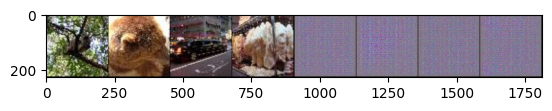

  2%|▏         | 10/500 [00:57<41:28,  5.08s/it, Epoch=1, Train_Loss=0.0974]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x10741aa80>>
Traceback (most recent call last):
  File "/Users/eliottvalette/Documents/Expand Nets/expandnetvenv/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 
  3%|▎         | 13/500 [01:11<43:12,  5.32s/it, Epoch=1, Train_Loss=0.0963]

In [48]:
decoder_model, history = run_training(
    encoder_model,
    decoder_model,
    optimizer,
    scheduler,
    device=device,
    num_epochs=20
)